In [33]:
import numpy as np
import cv2

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage
import os

In [35]:
def read_all_mias_dataset(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),0)
        
        if img is not None:
            img = cv2.resize(img,(64,64))
            images.append(img)
    return images

In [36]:
images = read_all_mias_dataset('data/all-mias/')
len(images)

322

In [37]:
len(images[0])

64

In [38]:
train_x = images[0:250]
test_x = images[250:]

In [39]:
x_train = np.array(train_x)
x_test = np.array(test_x)

In [40]:
#preprocessing
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))  # adapt this if using `channels_first` image data format


In [41]:
x_train[0].shape

(64, 64, 1)

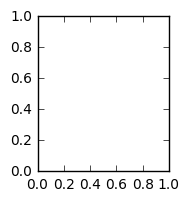

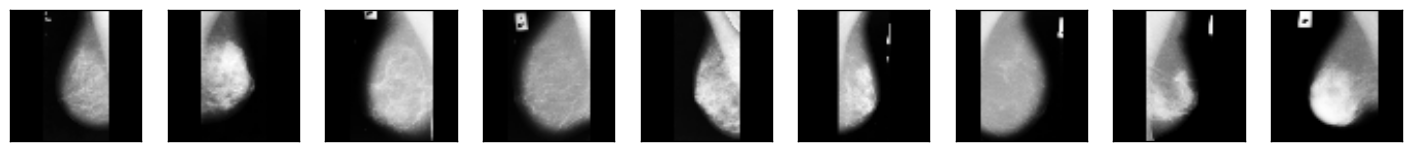

In [43]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [44]:
#adding noise
def salt_and_pepper(x_train,x_test,factor):
    noise_factor = factor
    
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [45]:
def gaussian_noise(x_train,x_test,sigma):
    row,col,ch= x_train[0].shape
    
    x_train_noisy = skimage.util.random_noise(x_train, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    x_test_noisy = skimage.util.random_noise(x_test, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [46]:
def gamma_noise(x_train,x_test,shape,scale=1.0):
    
    row,col,ch = x_train[0].shape
    
    x_train_noisy = x_train + np.random.gamma(shape,scale,x_train.shape)
    x_test_noisy = x_test + np.random.gamma(shape,scale,x_test.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [20]:
x_train_noisy,x_test_noisy = salt_and_pepper(x_train,x_test,0.5)

In [48]:
x_train_noisy,x_test_noisy = gaussian_noise(x_train,x_test,0.5)

In [17]:
x_train_noisy,x_test_noisy = gamma_noise(x_train,x_test,1,1)

In [49]:
x_train_noisy.shape

(250, 64, 64, 1)

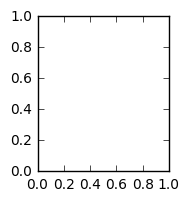

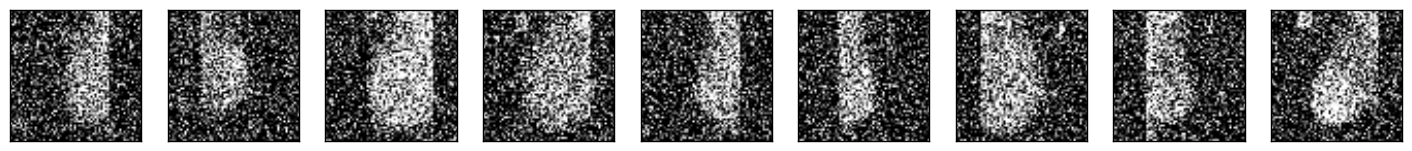

In [51]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [52]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard


Using TensorFlow backend.


In [53]:
input_img = Input(shape=x_train[0].shape)  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
__________

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 250 samples, validate on 72 samples
Epoch 1/20
250/250 [==============================] - 10s - loss: 0.6283 - val_loss: 0.6108
Epoch 2/20
250/250 [==============================] - 10s - loss: 0.5998 - val_loss: 0.5973
Epoch 3/20
250/250 [==============================] - 10s - loss: 0.5848 - val_loss: 0.5797
Epoch 4/20
250/250 [==============================] - 12s - loss: 0.5659 - val_loss: 0.5560

In [ ]:
out = autoencoder.predict(x_test_noisy,verbose=1)

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(out[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [38]:
import cv2

In [39]:
test_image = cv2.imread('data/two',0)


In [40]:
test_image = cv2.resize(test_image,(28,28))
test_image = np.expand_dims(test_image, axis=2)
gd= test_image
gd/=255

In [58]:
test_image = skimage.util.random_noise(test_image, mode='gaussian', seed=None, clip=True, mean=0, var=0.5**0.5)

In [76]:
test_image ,test_image1= salt_and_pepper(test_image,test_image,0.5)

In [41]:
test_image = test_image + np.random.gamma(1,1,test_image.shape)

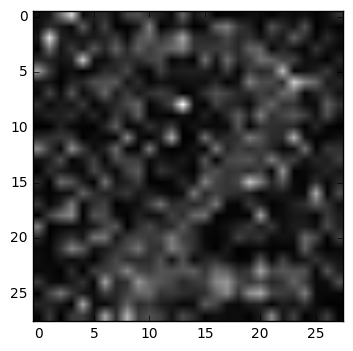

In [42]:
plt.imshow(test_image.reshape(28,28))
plt.show()

In [43]:
test=np.empty([1,28,28,1])
test[0]=test_image
pred = autoencoder.predict(test,verbose=1)

1/1 [==============================] - 0s


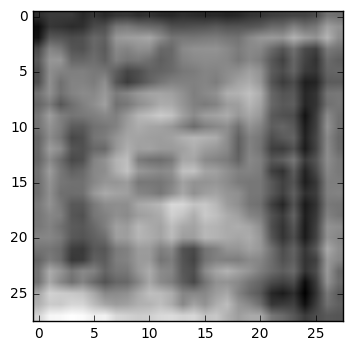

In [44]:
plt.imshow(pred.reshape(28,28))
plt.show()
pred = pred.reshape(28,28,1)

In [45]:
import math
def get_mse(imageA,imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [46]:
get_mse(test_image,pred)

1.7087172516546107

In [47]:
def get_psnr(imageA,imageB):
    maxI = 1
    try:
        return 20*math.log10(maxI) - 10*math.log10(get_mse(imageA,imageB))
    except:
        return 20*math.log10(maxI)

In [48]:
print get_psnr(pred,test_image)

-2.32670204204


In [49]:
print get_mse(pred,gd)
print get_mse(test_image,gd)
print get_mse(test_image,pred)

0.268607809634
2.08177803576
1.70871725165


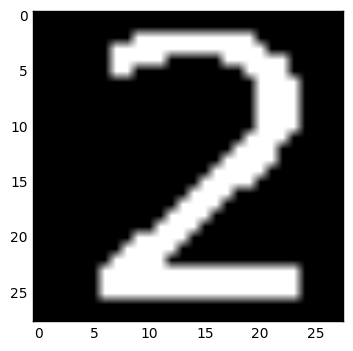

In [50]:
plt.imshow(gd.reshape(28,28))
plt.show()

In [51]:
print get_psnr(pred,gd)
print get_psnr(test_image,gd)
print get_psnr(test_image,pred)

5.70881364594
-3.18434422108
-2.32670204204
